In [1]:
# Normal setup and imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.conv_learner import *

### Why F2 instead of accuracy?
f2 is really fbeta_score from sklearn and that's the weighed harmonic mean of precision and recall. This is simply what the Kaggle competition choose to use as the metric. Precision is the true positives over the true positives + false positives. Accuracy is the true positives over the true positives + the false negatives. In this instance precision is weighted twice as high as recall (ie its twice as important to avoid predicting false positives as predicting false negatives).

In [2]:
from planet import *

metrics = [f2]
model = resnet34

PATH = '/home/paperspace/data/planet'

In [3]:
n = len(list(open(f'{PATH}/train_v2.csv')))-1 #-1 bc first row has labels
print(n)
sz = 256

40479


In [4]:
tfms = tfms_from_model(model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = get_data(PATH, tfms, 256)

In [5]:
# Take a look at the classes w/ the first validation target
list(zip(data.classes, data.val_y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 1.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 0.0)]

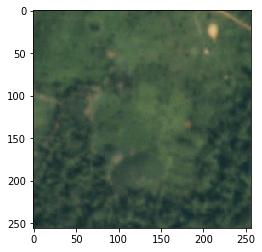

In [6]:
x, y = next(iter(data.val_dl)) # get batch of val dataset (denorm works with batches)
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.2) # print img to see what we're dealing with

In [7]:
data = get_data(PATH, tfms, n)
learn = ConvLearner.pretrained(model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.205742   0.286945   0.862316  



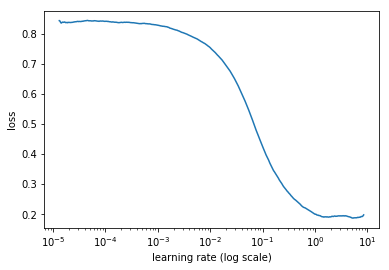

In [8]:
lrn_find = learn.lr_find()
learn.sched.plot()

In [9]:
lr = .3
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) 
# cycle_len is how many cycles to wait before resetting lr.
# note: usually lr starts decreasing after each epoch but occassionally resetting could help find a 'stable' min
# note: 'stable' min is a large local min which means if you change inputs it likely is still a min
# cycle_mult is how much to mult each cycle_len by after cycle
# so for this one lr resets after first epoch then 3rd epoch and stops at 7th epoch

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.126493   0.113936   0.90383   
    1      0.128521   0.109509   0.906877  
    2      0.118203   0.107143   0.909795  
    3      0.119884   0.107779   0.908044  
    4      0.119459   0.105085   0.911007  
    5      0.112476   0.103383   0.912904  
    6      0.111911   0.103302   0.913643  



[0.10330171, 0.9136428558782254]

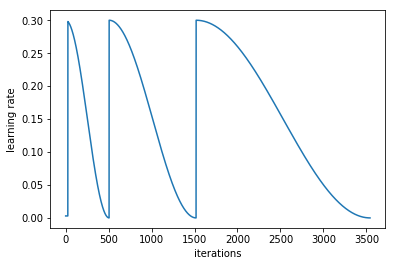

In [10]:
learn.sched.plot_lr()

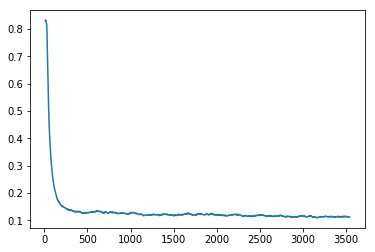

In [11]:
learn.sched.plot_loss()

In [12]:
lrs = np.array([lr/9, lr/3, lr])
learn.unfreeze()
learn.fit(lrs, n_cycle=4, cycle_len=1, cycle_mult=2)
learn.save('resnet34')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.100062   0.090618   0.925563  
    1      0.097673   0.089065   0.925489  
    2      0.091362   0.086546   0.928411  
    3      0.093372   0.088419   0.925862  
    4      0.091056   0.085285   0.929541  
    5      0.087946   0.083031   0.931328  
    6      0.083281   0.082137   0.932632  
    7      0.092196   0.088642   0.927112  
    8      0.088752   0.085698   0.929391  
    9      0.086571   0.084705   0.92985   
    10     0.084965   0.083258   0.93065   
    11     0.078077   0.082219   0.931493  
    12     0.078232   0.08266    0.932221  
    13     0.07773    0.08186    0.933077  
    14     0.076137   0.081913   0.932853  



In [13]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
f2(preds, y)

0.9304954364051197

This result is not quite as good as what Jeremy gets in the original notebook. He starts with a scaled down image size and goes through several rounds of training the last layer, then unfreezing and training all layers, then increasing image size/freeze/repeat. The difference is only .006 but perhaps that technique allows the layers to train with fewer heavy swings in the weights resulting in a better local min.